In [28]:
import pandas as pd
import numpy as np
import sys

from importlib import reload

import hdbscan

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt

sys.path.insert(1, '..')

import repsys

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
class MovieLens(repsys.Dataset):
    def name(self):
        return "movielens"

In [19]:
dataset = MovieLens()
dataset.load_dataset()

In [20]:
class KNN(repsys.Model):
  def __init__(self, k=10):
    self.model = NearestNeighbors(n_neighbors=k, metric="cosine")

  def name(self):
    return "KNN10"

  def fit(self):
    self.model.fit(self.dataset.train_data)

  def predict(self, X, **kwargs):
    distances, indexes = self.model.kneighbors(X)

    n_distances = distances[:, 1:]
    n_indexes = indexes[:, 1:]

    n_distances = 1 - n_distances

    sums = n_distances.sum(axis=1)
    n_distances = n_distances / sums[:, np.newaxis]

    predictions = np.array(
      [
        self.dataset.train_data[idx]
        .multiply(dist.reshape(-1, 1))
        .sum(axis=0)
        for idx, dist in zip(n_indexes, n_distances)
      ]
    ).squeeze(axis=1)

    return predictions

In [21]:
model = KNN(k=5)
model.update_data(dataset)
model.fit()

In [43]:
evaluator = repsys.Evaluator(model)
evaluator.evaluate_model(dataset.test_data_tr, dataset.test_data_te)
evaluator.print_results()

Recall@5=0.04777 (0.00115)
Recall@20=0.18055 (0.00222)
Recall@50=0.33979 (0.00285)
NCDG@100=0.19893 (0.00115)


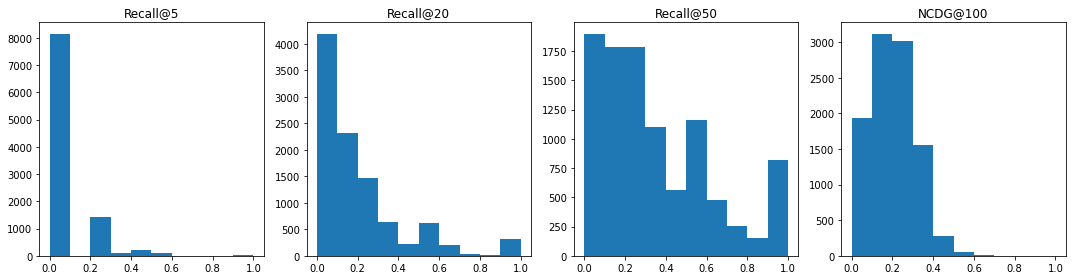

In [44]:
evaluator.plot_distributions()

## Embeddings Space

In [5]:
svd = TruncatedSVD(n_components=50, random_state=42, algorithm="arpack")
reduced_data = svd.fit_transform(dataset.vad_data_tr)

In [16]:
tsne = TSNE(perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(reduced_data)

In [18]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=12)
clusterer.fit(X_embedded)

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], c=clusterer.labels_)
plt.show()